
# PART II
## Parameter recovery, model validation, bootstrap

**In this tutorial, we will see how to:**

- Validate the modeling results against experimental data
- Test model recovery
- Use bootstrapping to estimate the uncertainty of fitted model parameters


In [ ]:
# define the github path and authorization token
RAW_GITHUB_PATH = 'https://raw.githubusercontent.com/bambschool/BAMB2024/main/1-modeling_101/'

# define the list of files to be downloaded
files = ['tutorial_1_lib.py']

for file in files:
  !wget -O {file} "{RAW_GITHUB_PATH}{file}"

--2024-09-19 19:55:12--  https://raw.githubusercontent.com/bambschool/BAMB2024/main/1-modeling_101/tutorial_1_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4696 (4.6K) [text/plain]
Saving to: ‘tutorial_1_lib.py’

tutorial_1_lib.py   100%[===================>]   4.59K  --.-KB/s    in 0s      

2024-09-19 19:55:12 (29.1 MB/s) - ‘tutorial_1_lib.py’ saved [4696/4696]



In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import pearsonr
import scipy.optimize as optimize

from tutorial_1_lib import *

**We use model B to generate fake data and in the following we assume that this is our actual experimental data.**

In [ ]:
# 1. Generate fake experimental data using Model B
n = 2500  # Number of trials
stim_values = [-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3]  # Possible stimulus values (signed stimulus strength)

# Define Model B parameters
sigma = 1  # Decision noise
Lambda = 0.2  # Lapse rate

# Generate experimental conditions and stimulus values for each trial
c = np.random.choice(a=['control', 'manipulation'], size=n)  # Condition
s = np.random.choice(a=stim_values, size=n)  # Stimulus evidence

# Simulate Model B to generate responses
r = simulate_modelB(s, c, sigma_d=sigma, Lambda=Lambda)

# Create a DataFrame with the experimental data
exp_data = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r})
exp_data  # Display the generated experimental data

,stimulus,condition,response
0,-3.0,control,0
1,-1.0,control,0
2,-0.5,manipulation,0
3,0.0,manipulation,0
4,1.0,manipulation,1
...,...,...,...
2495,1.0,manipulation,1
2496,3.0,control,1
2497,-2.0,control,0
2498,-1.0,manipulation,0


---
# II.1 Model validation


As a very simple example for model validation, we will fit model A and B to the experimental data and compare how well the best-fitting model fits the psychometric curve.

**Fit model B to the experimental data and show the model result and the psychometric curve.**


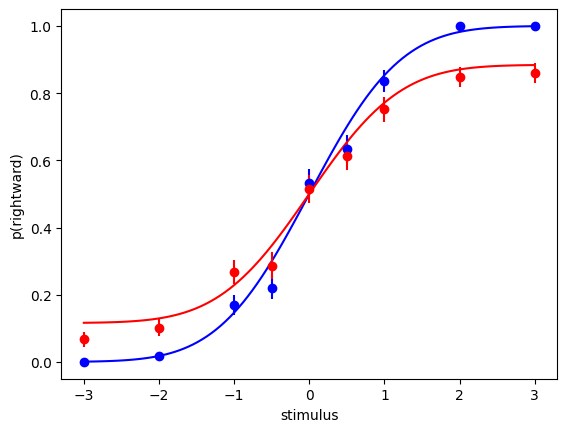

In [ ]:
# 2. Fit Model B to the experimental data
# Use maximum likelihood estimation to find the best-fitting parameters for Model B
p_opt = optimize.minimize(lambda pp: -LogLikelihood_modelB(exp_data, pp[0], pp[1]),
                          x0=[0.75, 0.1], bounds=[(0.1, 10), (0.01, 1)]).x

# Retrieve the optimized parameters
sigma_d_hat, Lambda_hat = p_opt

# Plot Model B's predictions and the psychometric curve
plot_model(lambda s, c: p_modelB(s, c, sigma_d=sigma_d_hat, Lambda=Lambda_hat))
plot_data_psychometric(exp_data)


**Now fit model A to the experimental data and compare to the result obtained above.**


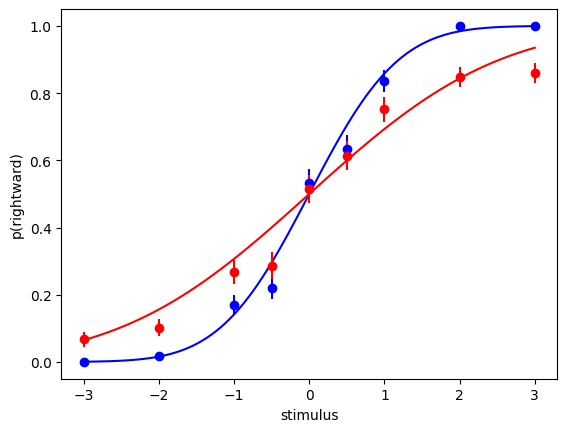

In [ ]:
# 3. Fit Model A to the experimental data
# Use maximum likelihood estimation to find the best-fitting parameters for Model A
p_opt = optimize.minimize(lambda pp: -LogLikelihood_modelA(exp_data, pp[0], pp[1]),
                          x0=[0.75, 0.1], bounds=[(0.1, 10), (0.1, 10)]).x

# Retrieve the optimized parameters for Model A
sigma_d_hat, sigma_m_hat = p_opt

# Plot Model A's predictions and the psychometric curve
plot_model(lambda s, c: p_modelA(s, c, sigma_d=sigma_d_hat, sigma_m=sigma_m_hat))
plot_data_psychometric(exp_data)


Fitting the experimental data with model A that does not include lapses but a different $\sigma_m$, we get a worse fit for all the data points and the slope of the fit does not seem right.

Of course, this is trivial here because we now that the "experimental data" actually includes lapses. It is important to note that not including a lapse rate can lead to real-world problems when fitting psychometric functions. We will talk more about this further below.


In general, it is a good idea to show not only that the best-fitting model validates, but that the alternative models do NOT validate (often many models are validated on simple behavioral metrics, and we need of specific patterns of behavior to arbitrate between different models).

---
# II.2. Parameter recovery


## Simulation and fitting

**Simulate Model B to generate synthetic data, then fit these data.**

We will do this step by step. We will first simulate model B using `simulate_modelB` with different random parameters $\sigma_d$ and $\lambda$. Note that the parameter recovery result will depend on the probability distribution used to sample the parameters.

After simulating the model, we will fit the parameters using a maximum likelihood approach to get estimated values $\hat{\sigma_d}$ and $\hat{\lambda}$.

In [ ]:
# 4. Parameter recovery setup
n_rep = 500  # Number of repetitions (i.e. number of synthetic datasets)
n = 2500  # Number of trials per repetition
stim_values = [-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3]  # Possible stimulus evidence values

# Initialize arrays to store true and fitted parameters
true_params = np.zeros((n_rep, 2))
fitted_params = np.zeros((n_rep, 2))

# 5. Loop over each repetition to simulate and fit Model B
for i in range(n_rep):
    # Randomly sample true sigma_d and Lambda for this repetition
    true_sigma = np.random.uniform(0.5, 2.0)  # Sample sigma_d
    true_lambda = np.random.uniform(0.01, 0.3)  # Sample Lambda

    # Store the true parameters
    true_params[i, 0] = true_sigma
    true_params[i, 1] = true_lambda

    # Generate experimental conditions and stimulus values
    c = np.random.choice(a=['control', 'manipulation'], size=n)  # Condition
    s = np.random.choice(a=stim_values, size=n)  # Stimulus evidence

    # Simulate Model B responses with the true parameters
    r = simulate_modelB(s, c, sigma_d=true_sigma, Lambda=true_lambda)

    # Create a DataFrame with the simulated data
    df_simulation = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r})

    # Fit Model B to the simulated data
    result = optimize.minimize(lambda pp: -LogLikelihood_modelB(df_simulation, pp[0], pp[1]),
                               x0=[0.75, 0.1], bounds=[(0.1, 10), (0.01, 1)])

    # Store the fitted parameters
    fitted_params[i, 0] = result.x[0]  # Fitted sigma_d
    fitted_params[i, 1] = result.x[1]  # Fitted Lambda


## Parameter recovery plots

We would like to visualise the fitted parameter values as a function of the generating parameter values. We will have one data point for each iteration. Here, you should use the generating values and the fitted values that you have stored in the section above. You should create two subplots, one for each parameter. Do you observe a fairly good agreement between the simulated and fit parameter values?

Correlation between fitted sigma_d and fitted Lambda: -0.037


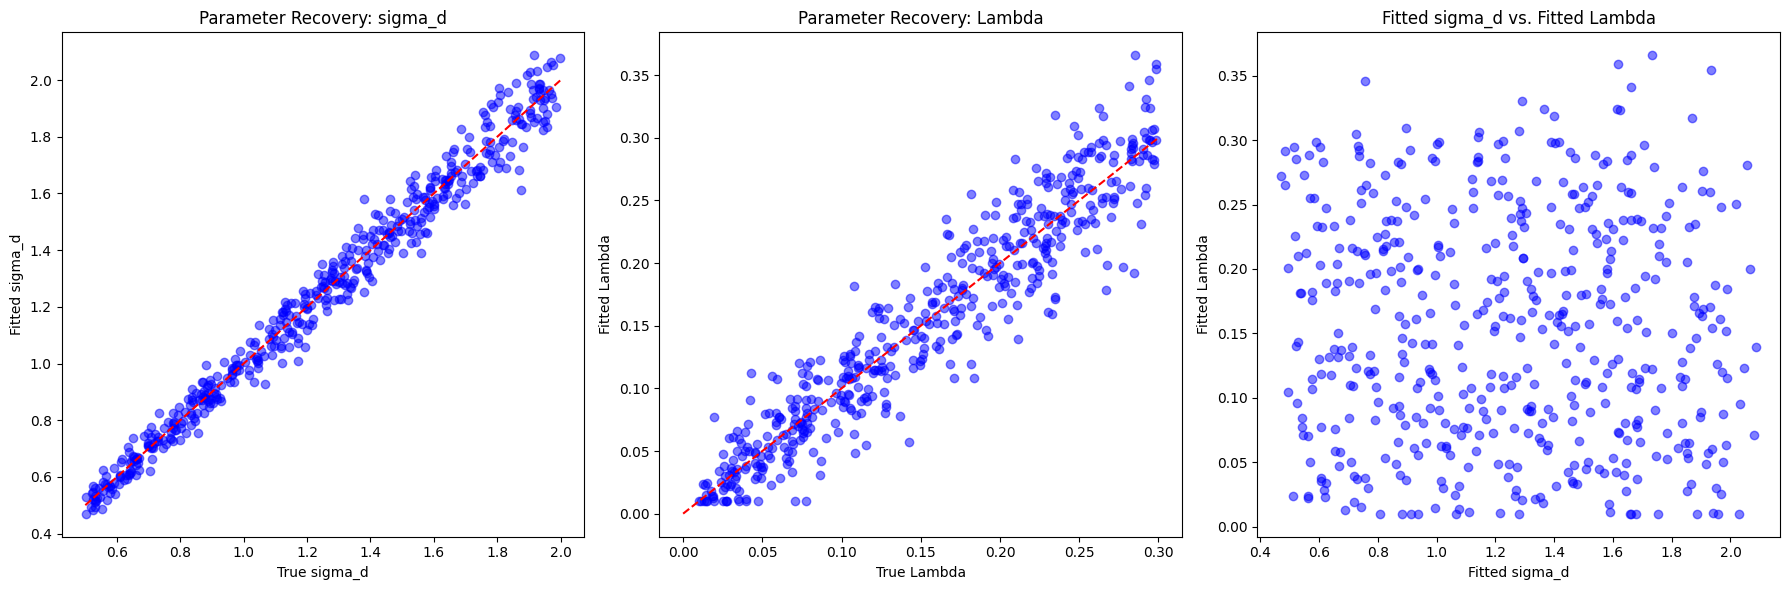

In [ ]:
# 6. Plot the true vs fitted parameters for sigma_d and Lambda
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for sigma_d
ax1.scatter(true_params[:, 0], fitted_params[:, 0], color='blue', alpha=0.5)
ax1.plot([0.5, 2], [0.5, 2], color='red', linestyle='--')  # Reference line
ax1.set_xlabel('True sigma_d')
ax1.set_ylabel('Fitted sigma_d')
ax1.set_title('Parameter Recovery: sigma_d')

# Scatter plot for Lambda
ax2.scatter(true_params[:, 1], fitted_params[:, 1], color='blue', alpha=0.5)
ax2.plot([0, 0.3], [0, 0.3], color='red', linestyle='--')  # Reference line
ax2.set_xlabel('True Lambda')
ax2.set_ylabel('Fitted Lambda')
ax2.set_title('Parameter Recovery: Lambda')

# Optional third subplot: fitted sigma_d vs. fitted Lambda
ax3.scatter(fitted_params[:, 0], fitted_params[:, 1], color='blue', alpha=0.5)
ax3.set_xlabel('Fitted sigma_d')
ax3.set_ylabel('Fitted Lambda')
ax3.set_title('Fitted sigma_d vs. Fitted Lambda')

# Calculate and display correlation between fitted sigma_d and Lambda
correlation, _ = pearsonr(fitted_params[:, 0], fitted_params[:, 1])
print(f'Correlation between fitted sigma_d and fitted Lambda: {correlation:.3f}')

# Adjust plot layout
plt.tight_layout()
plt.show()



These plots show strong correlation between true and fitted paramters and also reveal whether the correlation holds in some parameter regimes but not others. It also reveals any existing bias (e.g. a tendency to recover higher or lower values in average) which does not seem to be the case here.

Depending on the parameter values that we obtain when fitting human behavior, the worse correspondence in some parameter range may or may not be problematic. It is be a good idea to use the range of parameters obtained from fitting the real data to test the quality of recovery within the range that matters.

Reliable parameter recovery is particularly important for look at inter-individual differences in relation to questionnaire scores or brain data.


 **Optional:** Include a third subplot which shows a scatterplot of the fitted parameters $\sigma$ and $\lambda$. Also compute the correlation between the two parameters. How do you interpret the result?

Correlation coefficient: 0.006890080224426956
p-value: 0.8778596179990912


The fitted parameters are not correlated, indicating that our parameters are identifyable (they cannot be trade-off against each other)

---
# II.3 Parameter uncertainty estimation (bootstrap)


[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets.

To explore this idea, we will work againg wit the "experimental data" generated above (the DataFrame `exp_data`).


**Generate resampled data and display the psychometric curves for the original and the resampled data.** Repeat this several times to get a feeling for the "randomness", that is how different the resampled data is from the original data.


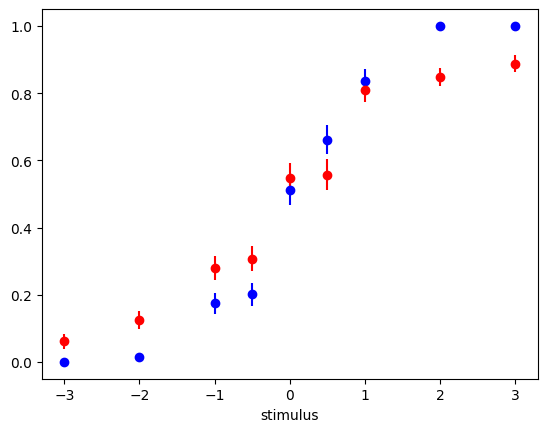

In [ ]:
# Generate a bootstrap sample from the experimental data
bootstrap_sample = exp_data.sample(n=len(exp_data), replace=True)

# Plot psychometric curves for both the original and the resampled data
#plot_data_psychometric(exp_data)         # Original data
plot_data_psychometric(bootstrap_sample) # Resampled data
# plt.legend(('Original', 'Resampled'))   # Optional: Show legend if desired

## Generate bootstrap estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of fitted parameters from a dataset.


We will do this for model B, that is, we will fit the model B and return an array with the fitted parameters $\sigma_m$ and $\lambda$.


In [ ]:
def bootstrap_estimates(data, n=2000):
    """
    Generate a set of theta_hat estimates using the bootstrap method.

    Args:
        data (DataFrame): Experimental data for fitting the model.
        n (int): The number of bootstrap samples to generate.

    Returns:
        ndarray: An array of estimated parameters with size (n, 2),
                 where each row contains [sigma_m, lambda].
    """
    # Initialize an array to hold the fitted parameters for each bootstrap sample
    theta_hats = np.zeros((n, 2))

    # Loop over the number of bootstrap iterations
    for i in range(n):
        # Resample data with replacement
        bootstrap_sample = data.sample(frac=1, replace=True)

        # Fit model B to the resampled data and optimize parameters sigma_m and lambda
        result = optimize.minimize(
            lambda pp: -LogLikelihood_modelB(bootstrap_sample, pp[0], pp[1]),
            x0=[0.75, 0.1],                 # Initial guess for [sigma_m, lambda]
            bounds=[(0.1, 10), (0.01, 1)]   # Bounds for parameters
        )

        # Store the fitted parameters (sigma_m, lambda)
        theta_hats[i, :] = result.x

    return theta_hats

# Get bootstrap estimates using 500 resamples
theta_hats = bootstrap_estimates(exp_data, n=500)
print(theta_hats[:5])  # Display the first few bootstrap estimates

[[0.95639009 0.24406641]
 [0.95615409 0.22976765]
 [0.89382772 0.2395695 ]
 [0.88561198 0.23705748]
 [0.96814977 0.22526634]]


## Plot bootstrap samples and confidence intervals

Let us now quantify how uncertain our estimated parameters ($\sigma_m$ and $\lambda$) are. We do so by computing confidence intervals from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.


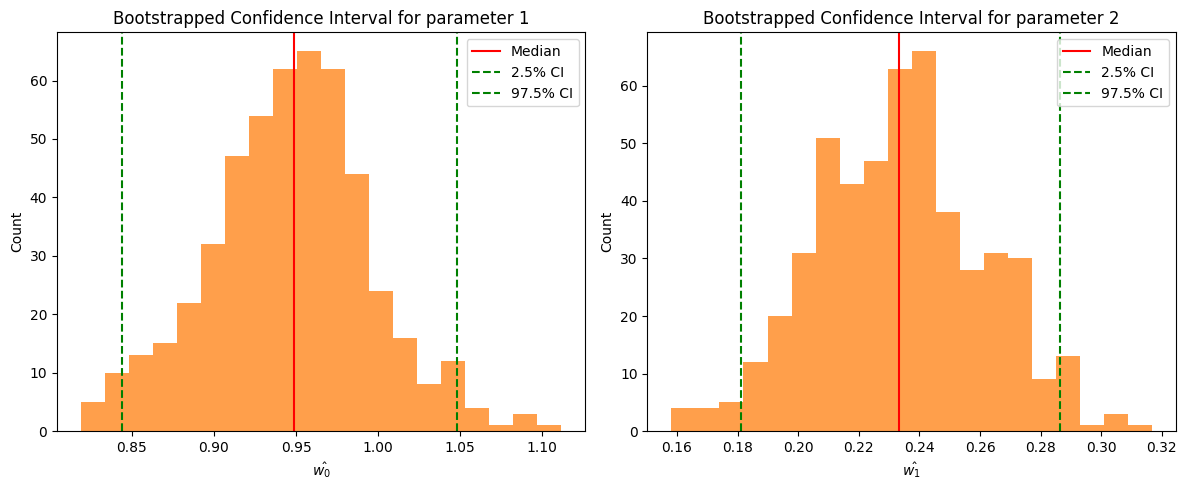

In [ ]:
# Compute summary statistics for the bootstrap estimates
means = np.mean(theta_hats, axis=0)            # Mean of the bootstrap estimates
stds = np.std(theta_hats, axis=0)              # Standard deviation of the estimates
medians = np.median(theta_hats, axis=0)        # Median of the estimates
CIs = np.percentile(theta_hats, [2.5, 97.5], axis=0)  # 95% confidence intervals

# Create histograms to visualize the bootstrap distributions and confidence intervals
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

for i in range(2):
    ax[i].hist(theta_hats[:, i], bins=20, facecolor='C1', alpha=0.75)  # Histogram of parameter estimates
    ax[i].axvline(medians[i], color='r', label='Median')               # Plot the median line

    # Show confidence intervals:
    ax[i].axvline(CIs[0, i], color='g', linestyle='--', label='2.5% CI')  # Lower CI bound
    ax[i].axvline(CIs[1, i], color='g', linestyle='--', label='97.5% CI') # Upper CI bound

    # Customize plot labels and legends
    ax[i].legend()
    ax[i].set(
        title=f'Bootstrapped Confidence Interval for parameter {i + 1}',
        xlabel=r'$\hat{{w_' + str(i) + '}}$',  # Parameter symbol
        ylabel='Count'
    )

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()          # Display the plot

## Illustrate bootstrap estimates (show fitted psychometric functions)

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are.

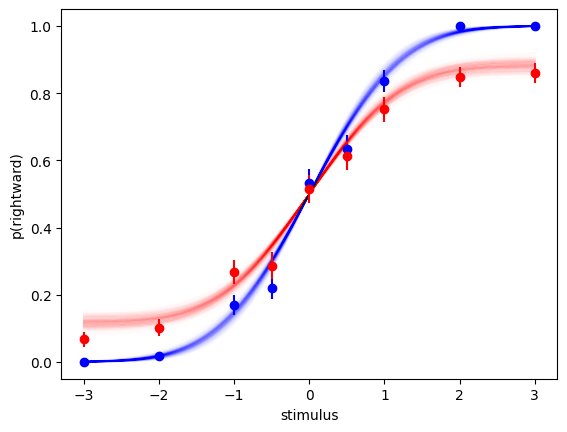

In [ ]:
# Create the plot for visualizing the fitted psychometric functions
fig, ax = plt.subplots()

# Plot all model fits obtained from the bootstrap samples
for i, theta_hat in enumerate(theta_hats):
    # Use the fitted sigma_d and Lambda from each bootstrap sample to plot the model
    plot_model(lambda s, c: p_modelB(s, c, sigma_d=theta_hat[0], Lambda=theta_hat[1]))

# Increase the transparency of the lines to better visualize the distribution of model fits
for line in plt.gca().lines:
    line.set_alpha(0.005)

# Plot the original psychometric curve from the experimental data for comparison
plot_data_psychometric(exp_data)

# Display the plot
plt.show()


## Summary of bootstrapping

- Bootstrapping is a resampling procedure that allows to build confidence intervals around inferred parameter values
- it is a widely applicable and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)
- is non-parametric: the confidence intervals provided by statistical libraries are not always accurate because they assume an underlying gaussian distribution for parameters, which is not always the case.

---
# Optional part: Parameter trade-off between $\lambda$ and $\sigma$


Above we have run a parameter recover analysis for model B that has a fixed $\sigma_c$ across the two experimental condtions, and only $\lambda$ is different between the conditions. Here, we will consider a more interesting example, let's call it model C. In model C, we also allow $\sigma_m$ to change between conditions, that is in the manipulated condition is now described by a $\lambda$ and a $\sigma_m$.

To make the above code direclty reusable, we simplify a bit and only consider "manipulation" trials.

**What do you observe, when using model B to fit the data obtained by model C?**